## Reed Data Retrieval

#### Imports

In [1]:
import glob
import json
import os
import pickle
import re
import sys
import time
from pprint import pprint
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import requests
from bs4 import BeautifulSoup
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import MultiLabelBinarizer

init_notebook_mode(connected=True)

#### Functions

In [2]:
def return_files(directory,string):
    '''Searches a specified directory for a file named with the specified string. Returns a list of file names.'''
    list_of_images = [
        os.path.basename(x) for x in glob.glob("{}\{}*.*".format(directory,string))
    ]

    return list_of_images

In [3]:
def parse_skills(x, ext=False):
    '''Searches a Pandas Series object for keywords which match a list. Returns a list of matching keywords'''
    all_text = BeautifulSoup(x).get_text(separator=" ").lower()
    count = 0
        
    if ext:
        skills = ext_keywords
        skills_dict = ext_keywords_dict
    else:
        skills = keywords
        skills_dict = keywords_dict
        
    for i in skills:
        all_text = re.sub(
            r"\b{}\b".format(re.escape(i).lower()),
            " id_{} ".format(count),
            all_text,
        )
        count += 1

    all_text = all_text.split()
    
    temp = list({j[0] for j in skills_dict.items() for i in all_text if i == j[1]})

    if len(temp) != 0:
        return temp

#### Variables

In [4]:
locations = pickle.load(open("locations.pickle", "rb")) # Dictionary of locations w/ countries as keys, citites as values

# Queries to search reed job listings with
queries = [
    "Data Engineer",
    "Data Scientist",
    "Data Analyst",
    "Data",
    "Developer",
    "Computer Science", 
    "Software Engineer",
    "Python",
    "SQL",
    "NoSQL",
    "Hadoop",
    "Machine Learning",
    "Apache",
    "Tableau",
]

direct_employer = ["true"] # Searches for jobs directly from an employer
graduate = ["true"] # Searches for jobs which require graduates

# Job titles to exclude
exclude_titles = [  
    "Process",
    "Field",
    "Application",
    "Structural",
    "Mechanical",
    "Quality",
    "Electronics",
    "Service",
    "Infrastructure",
    "cabling",
    "Teacher",
    "Economics",
    "Assistant",
    "Machinist",
    "Geotechnical",
    "Telephone Interviewers",
]
exclude_employers = ['The Training Room IT Careers'] # Employers to exclude

# keywords to look for in the job description
keywords = [
    "Python",
    "SQL",
    "NoSQL",
    "Hadoop",
    "Machine Learning",
    "Apache",
    "Tableau",
    "Spark",
    "Database",
    "Excel",
    "ML",
    "AI",
]

# extra keywords to look for in the job description
ext_keywords = [ 
    "C#",
    "Javascript",
    "HTML",
    "CSS",
    "java",
    "jQuery",
    "PHP",
    "C++",
    "Pearl",
]


#### Job Listings

In [ ]:
results_df = [] # Holds a list of dictionaries containing job information
error_lst = [] # Holds a list of urls which caused an error
count = 0 # Counts how many URL requests have been made
time_to_sleep = 4000 # Time for code to sleep if the API request limit is hit
range_results = 5 # How many pages/groups of results to loop through if query results exceed 100
#direct_employer = ["true", "false"]
#graduate = ["true", "false"]
results_to_take = 100 # maximum no. of results to retrieve per request

# Loops through all locations
for g in direct_employer:
    for h in graduate:
        for i in queries:
            for j in locations:
                for k in j["Cities"]:

                    # Skipping previously downloaded data
                    if count < 0:
                        count += 1
                        continue

                    else:
                        for l in range(range_results):

                            url = "https://www.reed.co.uk/api/1.0/search?keywords={}&locationName={}&distanceFromLocation={}&postedByDirectEmployer={}&graduate={}&resultsToTake={}&resultsToSkip={}".format(
                                i, k, 10, g, h, results_to_take, l * results_to_take
                            )

                            try:
                                req = requests.get(
                                    url,
                                    auth=("c2042b7e-7785-4e2e-ab50-04dfb5e38bb4", ""),
                                )

                                # Pausing and restarting the query if api request limit has been hit
                                if req.json().get("message") is not None:
                                    print(
                                        "Error: Hit api request limit count at count: {}, now sleeping at {}".format(
                                            count,
                                            time.strftime(
                                                "%d/%m/%Y_%H:%M:%S", time.localtime()
                                            ),
                                        )
                                    )
                                    time.sleep(time_to_sleep)
                                    req = requests.get(
                                        url,
                                        auth=(
                                            "c2042b7e-7785-4e2e-ab50-04dfb5e38bb4",
                                            "",
                                        ),
                                    )

                                results = req.json()["results"]
                                
                                # if no results, continue the loop
                                if len(results) == 0:
                                    count += 1
                                    continue
                                else:
                                    for m in results:
                                        m["direct_employer"] = g
                                        m["graduate"] = h
                                        m["query"] = i
                                    results_df.extend(results)

                           
                                # write results to appropriately named csv
                                export_df = results
                                export_df = pd.DataFrame.from_dict(export_df)
                                export_df.to_csv(
                                    r"Results\Indeed_{}_{}_{}.csv".format(
                                        i,
                                        k,
                                        time.strftime(
                                            "%d-%m-%Y_%H-%M-%S", time.localtime()
                                        ),
                                    ),
                                    index=False,
                                )

                                
                                # Present an update of status
                                print(
                                    "Search: {}, City: {}, Direct: {}, Graduate: {}, Range: {}, Count: {}".format(
                                        i,
                                        k,
                                        g,
                                        h,
                                        "{}-{}".format(l * 100, (l * 100) + 100),
                                        count,
                                    )
                                )
                                count += 1
                                
                            except Exception as e:
                                error_lst.append(url)
                                print("Url: {}, has been added at count: {}".format(url, count))
                                print(e)
                                
                                count += 1
                                
                                continue
                                

#### Cleaning Job Listings

In [5]:
list_of_files = return_files(r"Results/", "Indeed_") # Retrieve all downloaded csv names

master_df = []
for i in list_of_files:
    try:
        test = pd.read_csv("Results\{}".format(i))
        test = test.to_dict(orient="records")
    except:
        continue
    master_df.extend(test)

master_df_dirty = pd.DataFrame.from_dict(master_df) # DataFrame containing all downloaded job listings


# Cleaning the master dataframe
master_df = master_df_dirty
master_df.drop_duplicates(subset=['jobId'], keep="first", inplace=True) # Dedupe the same jobs
master_df.drop_duplicates(subset=['jobDescription','locationName'], keep="first", inplace=True) # Dedupe jobs with the same job description in the same location
master_df = master_df[
    [
        "jobId",
        "employerName",
        "locationName",
        "jobTitle",
        "jobDescription",
        "minimumSalary",
        "maximumSalary",
        "query",
        "direct_employer",
        "graduate",
    ]
]

# Renaming column names for readability
master_df.rename(
    index=str,
    columns={
        "jobId": "Job ID",
        "employerName": "Employer",
        "locationName": "Location",
        "jobTitle": "Title",
        "jobDescription": "Description",
        "minimumSalary": "Min. Salary",
        "maximumSalary": "Max. Salary",
        "query": "Search Query",
        "direct_employer":"Direct",
        "graduate":"Graduate",
    },
    inplace=True,
)

# 
master_df = master_df[~master_df['Title'].str.lower().str.contains('|'.join(exclude_titles).lower())]
master_df.reset_index(drop=True, inplace=True)
master_df.head()

c:\users\david\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Job ID,Employer,Location,Title,Description,Min. Salary,Max. Salary,Search Query,Direct,Graduate
0,37181828,Apache Associates,Falkirk,UI/UX Designer - HTML - CSS - Wireframing and ...,UX Designer - Wireframing and UI prototyping ...,40000.0,45000.0,Apache,False,False
1,37062977,Apache Associates,Stirling,Web Developer,Expanding company requires a Mid to Senior Le...,30000.0,35000.0,Apache,False,False
2,37029760,Apache Associates,Stirling,Web Developer,Expanding company requires a Mid to Senior Le...,250.0,350.0,Apache,False,False
3,37070524,Apache Associates,Falkirk,Software Project Manager,"Overview - Project Management, Full Project L...",35000.0,40000.0,Apache,False,False
4,36730080,John Ross Associates,Cardiff,PHP Developer - Back End / LAMP Stack / MySQL ...,PHP Developer - Back End / LAMP Stack / MySQL...,30000.0,35000.0,Apache,False,False


In [ ]:
master_df.describe()

In [7]:
master_df_overall = master_df.groupby(by="Employer").nunique().sort_values(by="Job ID", ascending=False) # Counts number of unique jobs by employer
master_df_overall

,Job ID,Employer,Location,Title,Description,Min. Salary,Max. Salary,Search Query,Direct,Graduate
Employer,,,,,,,,,,
Hays Specialist Recruitment Limited,632,1,111,491,628,133,149,14,1,2
Harnham,536,1,33,282,535,49,46,14,1,1
The Training Room IT Careers,425,1,196,4,6,1,2,4,2,2
Dawson and Walsh,175,1,82,158,173,18,20,9,1,1
Oscar Technology,169,1,44,148,169,33,35,13,1,1
REED,151,1,80,119,146,54,63,9,2,2
Search Consultancy,137,1,46,129,137,22,24,11,1,2
Nuffield Health,119,1,116,6,6,3,3,2,2,2
Avanti,118,1,46,97,114,16,19,12,1,1


#### Retrieving Direct Job IDs

In [8]:
direct_df = master_df[master_df['Direct'] == True] # Filters master_df for only job listings directly from the employer
direct_df = direct_df[~direct_df['Employer'].str.lower().str.contains('|'.join(exclude_employers).lower(), na=False)] # Removes irrelevant employers
direct_df.reset_index(drop=True, inplace=True)
direct_df.head()

,Job ID,Employer,Location,Title,Description,Min. Salary,Max. Salary,Search Query,Direct,Graduate
0,37094004,Intouch Games Ltd,Birmingham,"Senior C++ Programmer - C++, Linux (Debian)",Job Title: Senior C&#43;&#43; Programmer - C&...,40000.0,50000.0,Apache,True,False
1,37093983,Intouch Games Ltd,Birmingham,"Mid-level C++ Programmer - C++, Linux (Debian)",Job Title: Mid-level C&#43;&#43; Programmer -...,30000.0,40000.0,Apache,True,False
2,36437884,QA Consulting,Birmingham,Graduate Software Development Consultant,Graduate Software Development Consultant Do y...,23500.0,26500.0,Apache,True,False
3,36206305,Advanced,Leeds,Software Engineer Java,Software Engineer (Java) You will be a key me...,NaN,NaN,Apache,True,False
4,36206299,Advanced,Leeds,Senior Cloud Operations Analyst,Senior Cloud Operations Analyst Key aspects o...,NaN,NaN,Apache,True,False


In [9]:
direct_df_overall = direct_df.groupby(by="Employer").nunique().sort_values(by="Job ID", ascending=False) # Counts number of unique jobs by employer
direct_df_sum = direct_df_overall.sum(axis=0)
direct_df_overall

,Job ID,Employer,Location,Title,Description,Min. Salary,Max. Salary,Search Query,Direct,Graduate
Employer,,,,,,,,,,
Nuffield Health,112,1,109,6,6,3,3,2,1,2
CenturyLink,108,1,95,3,4,1,1,2,1,2
NTT,92,1,92,1,1,1,1,1,1,2
Sheridan Maine,65,1,20,44,65,28,30,2,1,1
Aon,53,1,13,53,53,1,1,3,1,2
Kantar Group Limited,41,1,7,40,41,0,0,5,1,2
Aberdeenshire council,41,1,14,30,40,24,25,2,1,1
Optical Express,33,1,19,8,33,0,0,2,1,1
Arcadis,29,1,9,28,28,1,1,4,1,2


In [10]:
list_of_jobids = direct_df['Job ID'].tolist() # Creats a list of job Ids we would like to retrieve the whole description from

## Retrieving All Job Descriptions

#### Example of a job Id query

In [12]:
url = "https://www.reed.co.uk/api/1.0/jobs/{}".format(37094004)
req = requests.get(url, auth=("c2042b7e-7785-4e2e-ab50-04dfb5e38bb4", ""))
job_info = req.json()
job_info

{'employerId': 420428,
 'employerName': 'Intouch Games Ltd',
 'jobId': 37094004,
 'jobTitle': 'Senior C++ Programmer - C++, Linux (Debian)',
 'locationName': 'Birmingham',
 'minimumSalary': 40000.0,
 'maximumSalary': 50000.0,
 'yearlyMinimumSalary': 40000.0,
 'yearlyMaximumSalary': 50000.0,
 'currency': 'GBP',
 'salaryType': 'per annum',
 'salary': '£40,000 - £50,000 per annum',
 'datePosted': '22/01/2019',
 'expirationDate': '05/03/2019',
 'externalUrl': None,
 'jobUrl': 'https://www.reed.co.uk/jobs/senior-c-programmer-c-linux-debian/37094004',
 'partTime': False,
 'fullTime': True,
 'contractType': 'Permanent',
 'jobDescription': " <p><strong>Job Title:</strong> Senior C&#43;&#43; Programmer - C&#43;&#43;, Linux (Debian)</p> <p><strong>Location:</strong> Birmingham, Halesowen (inc in-house relocation assistance)</p> <p><strong>Salary:</strong> &#163;40,000 - &#163;50,000 &#43; benefits (including flexible working hours &#43; bi-annual salary reviews)</p> <p><strong>Keywords:</strong>

#### Retrieving Data Within each Job ID

In [ ]:
results_df = [] # Holds a list of dictionaries containing job information
error_lst = [] # Holds a list of urls which caused an error
count = 0 # Counts how many URL requests have been made
time_to_sleep = 4000 # Time for code to sleep if the API request limit is hit


# Loops through all Job IDS
for i in list_of_jobids:

    # Skipping previously downloaded data
    if count < 0:
        count += 1
        continue

    else:
        url = "https://www.reed.co.uk/api/1.0/jobs/{}".format(i)

        try:
            req = requests.get(url, auth=("c2042b7e-7785-4e2e-ab50-04dfb5e38bb4", ""))

            # Pausing and restarting the query if api request limit has been hit
            if req.json().get("message") is not None:
                print(
                    "Error: Hit api request limit count at count: {}, now sleeping at {}".format(
                        count, time.strftime("%d/%m/%Y_%H:%M:%S", time.localtime())
                    )
                )
                time.sleep(time_to_sleep)
                req = requests.get(
                    url, auth=("c2042b7e-7785-4e2e-ab50-04dfb5e38bb4", "")
                )

            results = req.json()
            

            if len(results) == 0:
                count += 1
                continue
            else:
                results_df.extend(results)

            export_df = results
            export_df = pd.DataFrame.from_dict([export_df])
            export_df.to_csv(r"Results_JobIDs\Indeed_{}.csv".format(i), index=False)

            print("Job ID: {}, Complete".format(i))
            count += 1

        except Exception as e:
            error_lst.append(url)
            print("Url: {}, has been added at count: {}".format(url, count))
            print(e)

            count += 1

            continue

In [32]:
list_of_jobs = return_files(r"Results_JobIDs/", r"Indeed_")

job_df = []
for i in list_of_jobs:
    try:
        test = pd.read_csv("Results_JobIDs\{}".format(i))
        test = test.to_dict(orient="records")
    except:
        continue
    job_df.extend(test)

job_df_dirty = pd.DataFrame.from_dict(job_df)

job_df_overall = job_df_dirty.groupby(by="employerName").nunique().sort_values(by="jobId", ascending=False)

job_df_overall.head()

,applicationCount,contractType,currency,datePosted,employerId,employerName,expirationDate,externalUrl,fullTime,jobDescription,...,jobTitle,jobUrl,locationName,maximumSalary,minimumSalary,partTime,salary,salaryType,yearlyMaximumSalary,yearlyMinimumSalary
employerName,,,,,,,,,,,,,,,,,,,,,
Nuffield Health,14,2,1,4,2,1,5,5,2,6,...,7,112,109,3,3,2,3,2,3,3
CenturyLink,40,1,1,5,2,1,2,2,1,4,...,3,108,95,1,1,1,1,1,1,1
NTT,30,1,1,2,1,1,1,3,1,1,...,1,92,92,1,1,1,1,1,1,1
Sheridan Maine,18,3,1,32,1,1,23,0,1,65,...,44,65,20,30,28,1,44,3,30,28
Aon,29,2,1,28,1,1,26,52,1,53,...,53,53,13,1,1,1,1,1,1,1


In [33]:
# Creates two dictionaries for the "parse_skills" function
list_keywords = [keywords, ext_keywords]

keywords_dict = {}
ext_keywords_dict = {}

for i in list_keywords:
    count = 0
    for j in i:
        if j in keywords:
            keywords_dict["{}".format(j)] = "id_{}".format(count)

        else:
            ext_keywords_dict["{}".format(j)] = "id_{}".format(count)
        
        count += 1

job_df_skills = job_df_dirty.copy()
job_df_skills["skills"] = job_df_skills["jobDescription"].map(lambda x: parse_skills(x)) # Creates a column with list of keywords matching the "keywords" variable
job_df_skills["ext_skills"] = job_df_skills["jobDescription"].map(lambda x: parse_skills(x,True)) # Creates a column with list of keywords matching the "ext_keywords" variable

found_df = job_df_skills[~job_df_skills['skills'].isnull()] # Filters for rows where skills are not null

s = found_df['skills']

skills_list = s.tolist()
skills_true = []
for i in skills_list:
    skills_true.append(i[0])
skills_true = set(skills_true)
skills_true.remove('ML')


# Converts list of skills to columns, (supposedly a faster version of "pandas.get_dummies")
mlb = MultiLabelBinarizer()
skills_df = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=found_df.index)

found_df = pd.concat([found_df[['jobId','locationName','employerName','jobTitle','minimumSalary','maximumSalary']], skills_df], axis=1)

# Combines "Machine Learning" with "ML"
found_df["Machine Learning"] = np.where(
        (found_df["Machine Learning"] + found_df["ML"]) == 2,
        1,
        found_df["Machine Learning"],
        )
found_df.drop(columns=["ML"], inplace=True)

## Visualisation

#### Jobs/Employer

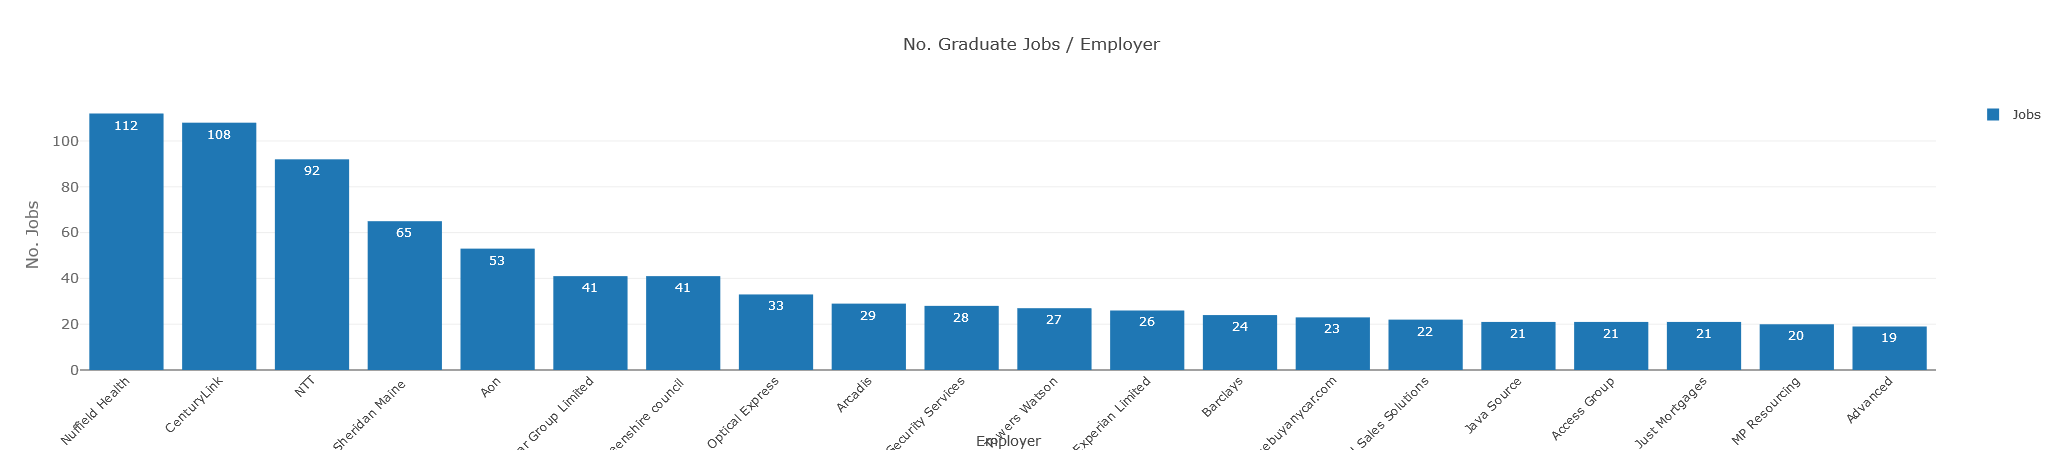

In [38]:
job_df_top_20 = job_df_overall.nlargest(20, "jobId")

data = [go.Bar(x=job_df_top_20.index, y=job_df_top_20["jobId"], name="Jobs", text=job_df_top_20["jobId"], textposition = 'auto',)]

layout = go.Layout(
    xaxis=dict(tickangle=-45, title="Employer"),
    barmode="stack",
    yaxis=dict(
        title="No. Jobs",
        titlefont=dict(size=16, color="rgb(107, 107, 107)"),
        tickfont=dict(size=14, color="rgb(107, 107, 107)"),
    ),
    title="No. Graduate Jobs / Employer",
    showlegend=True,
)
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename="job_employer.html")

#### Jobs/Location
##### Note: Does not necessarily include specifically mentioned skills found in the "keywords" variable

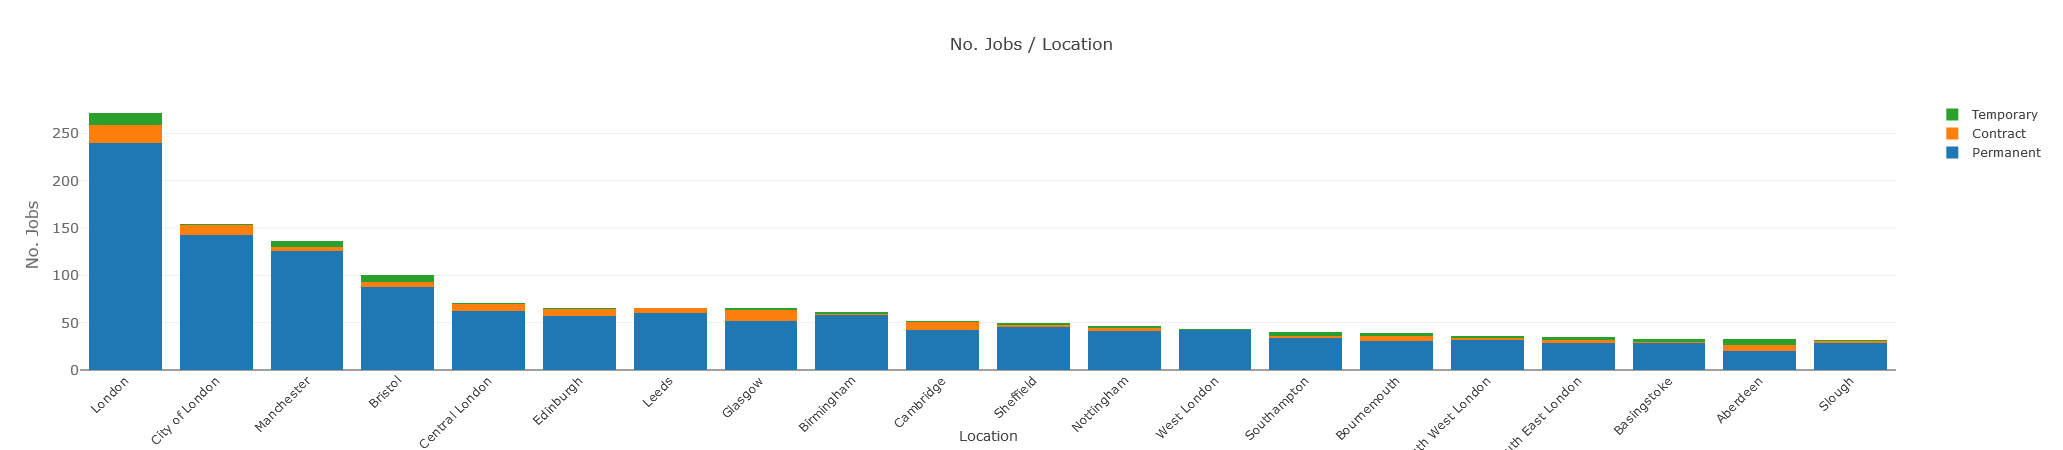

In [39]:
job_df_location = job_df_dirty.copy()

job_df_location = job_df_location.groupby(by="locationName").nunique().sort_values(by="jobId", ascending=False)

job_df_top_20 = job_df_location.nlargest(20, 'jobId')

top_companies_list = job_df_top_20.index.tolist()

top_companies_df = job_df_dirty[job_df_dirty['locationName'].isin(top_companies_list)]

contract_types = set(top_companies_df['contractType'].tolist())

graphs = []

for i in contract_types:
    temp = {}
    temp_df = top_companies_df[top_companies_df['contractType'] == "{}".format(i)].groupby(by="locationName").nunique()
    temp_df = temp_df.reindex(top_companies_list)
    temp['x'] = temp_df.index.tolist()
    temp['y'] = temp_df['jobId'].tolist()
    temp["name"] = i
    temp["type"] = "bar"
    graphs.append(temp)
    
layout = go.Layout(
    xaxis=dict(tickangle=-45,title='Location'), barmode='stack',
    yaxis=dict(
        title='No. Jobs',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    title='No. Jobs / Location',
    showlegend=True
    
)

fig = go.Figure(data=graphs, layout=layout)
iplot(fig, filename='job_location_contract.html')

#### Skills/Salary

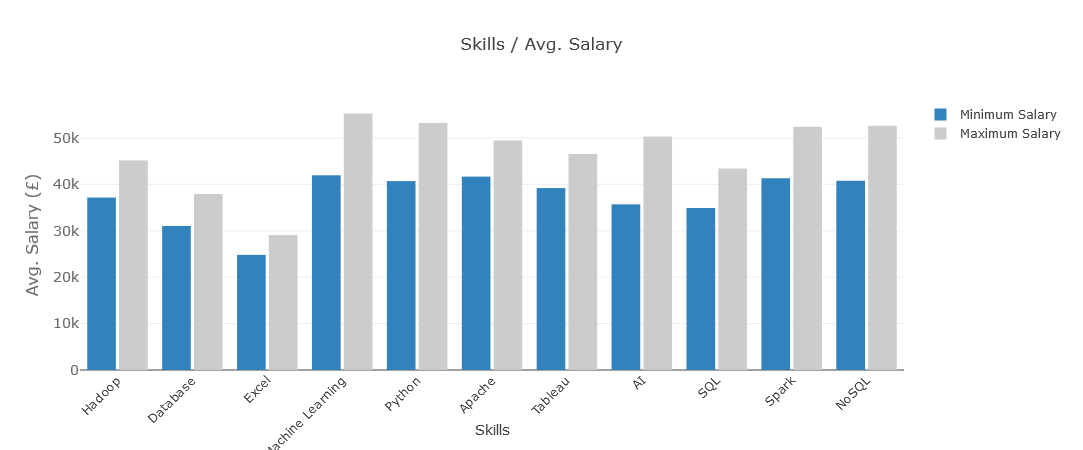

In [157]:
graphs = []
salaries = ["minimumSalary", "maximumSalary"]

minimum_sal = []
maximum_sal = []


for j in salaries:
    for i in skills_true:
        temp = {}
        temp_df = found_df[found_df["{}".format(i)] == 1]
        temp_df = temp_df.groupby(by=["{}".format(i)])["{}".format(j)].mean()
        temp["Skills"] = i
        temp["Avg. Salary"] = temp_df.iloc[0]
        if j == "minimumSalary":
            minimum_sal.append(temp)
        else:
            maximum_sal.append(temp)
            
            
min_pd = pd.DataFrame.from_dict(minimum_sal)
max_pd = pd.DataFrame.from_dict(maximum_sal)
        
min_bar = go.Bar(
    y=min_pd['Avg. Salary'].tolist(),
    x=min_pd['Skills'].tolist(),
    name='Minimum Salary',
    marker=dict(
        color="rgb(49,130,189)"
    )
)

max_bar = go.Bar(
    y=max_pd['Avg. Salary'].tolist(),
    x=max_pd['Skills'].tolist(),
    name='Maximum Salary',
    marker=dict(
        color="rgb(204,204,204)"
    )
)

data = [min_bar, max_bar]

layout = go.Layout(
    xaxis=dict(tickangle=-45,title='Skills'),barmode="group",
    yaxis=dict(
        title='Avg. Salary (£)',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    bargap=0.15,
    bargroupgap=0.1,
    title='Skills / Avg. Salary',
    showlegend=True
    
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename="skills_salary.html")

#### Skills/Salary Box-plot

In [173]:
graphs = []
salaries = ["minimumSalary", "maximumSalary"]

for j in salaries:
    for i in skills_true:
        temp = {}
        temp_df = found_df[found_df["{}".format(i)] == 1]
        temp['y'] = temp_df[j]
        temp['x'] = temp_df[i].replace(1, i)
        temp["type"] = "box"
        temp['boxmean']=True
        if j == "minimumSalary":
            temp['name'] = "{} - Min. Salary".format(i)
            temp['marker'] = dict(
                            color="rgb(49,130,189)"
                            )
        else:
            temp['name'] = "{} - Max. Salary".format(i)
            temp['marker'] = dict(
                            color="rgb(204,204,204)"
                            )
        graphs.append(temp)   
    
layout = go.Layout(
    xaxis=dict(tickangle=-45,title='Skills'),barmode="group",
    yaxis=dict(
        title='Salary (£)',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    boxmode='group',
    title='Skills / Salary',
    showlegend=False
    
)

fig = go.Figure(data=graphs, layout=layout)
plot(fig, filename="skills_salary.html")

'file://E:\\Work\\skills_salary.html'

#### Skills/Location
##### Note: Does only includes specifically mentioned skills found in the "keywords" variable + includes overlap of skills

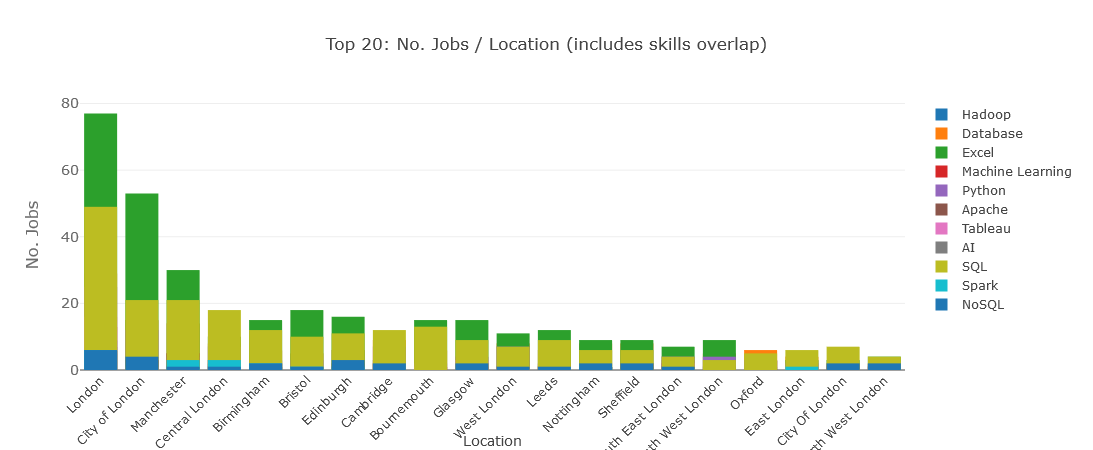

In [169]:
job_df_location = found_df.groupby(by="locationName").sum()
job_df_location['Total'] = job_df_location[list(skills_true)].sum(axis=1)

job_df_top_20 = job_df_location.nlargest(20, 'Total') # Can order by value the value of keywords by changing 'Total' to keywords[0] (Python)

top_companies_list = job_df_top_20.index.tolist()

graphs = []

for i in skills_true:
    temp = {}
    temp_df = found_df[found_df["{}".format(i)] == 1]
    temp_df = temp_df.groupby(by=["locationName"]).nunique()
    temp_df = temp_df.reindex(top_companies_list)
    temp['x'] = temp_df.index.tolist()
    temp['y'] = temp_df['jobId'].tolist()
    temp["name"] = i
    temp["type"] = "bar"
    graphs.append(temp)
            
            
layout = go.Layout(
    xaxis=dict(tickangle=-45,title='Location'), barmode='overlay',
    yaxis=dict(
        title='No. Jobs',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    title='Top 20: No. Jobs / Location (includes skills overlap)',
    showlegend=True
    
)

fig = go.Figure(data=graphs, layout=layout)
iplot(fig, filename='jobs_locations_skills.html')

#### Jobs/Location (Only Mentioned Skills)

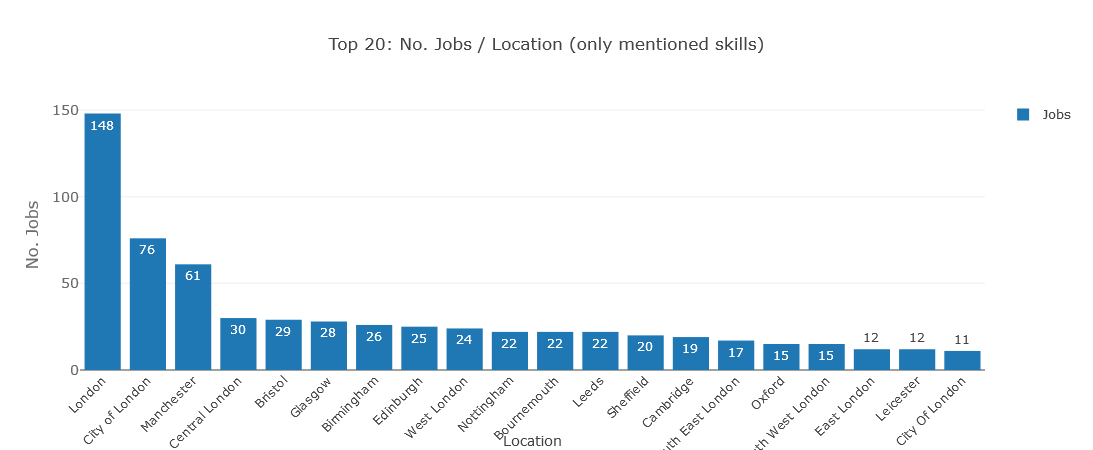

In [170]:
job_df_top_20 = found_df.groupby(by="locationName").nunique().sort_values(by="jobId", ascending=False).nlargest(20, "jobId")

data = [go.Bar(x=job_df_top_20.index, y=job_df_top_20["jobId"], name="Jobs", text=job_df_top_20["jobId"], textposition = 'auto',)]

layout = go.Layout(
    xaxis=dict(tickangle=-45, title="Location"),
    barmode="stack",
    yaxis=dict(
        title="No. Jobs",
        titlefont=dict(size=16, color="rgb(107, 107, 107)"),
        tickfont=dict(size=14, color="rgb(107, 107, 107)"),
    ),
    title="Top 20: No. Jobs / Location (only mentioned skills)",
    showlegend=True,
)
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename="jobs_location_skills_count.html")

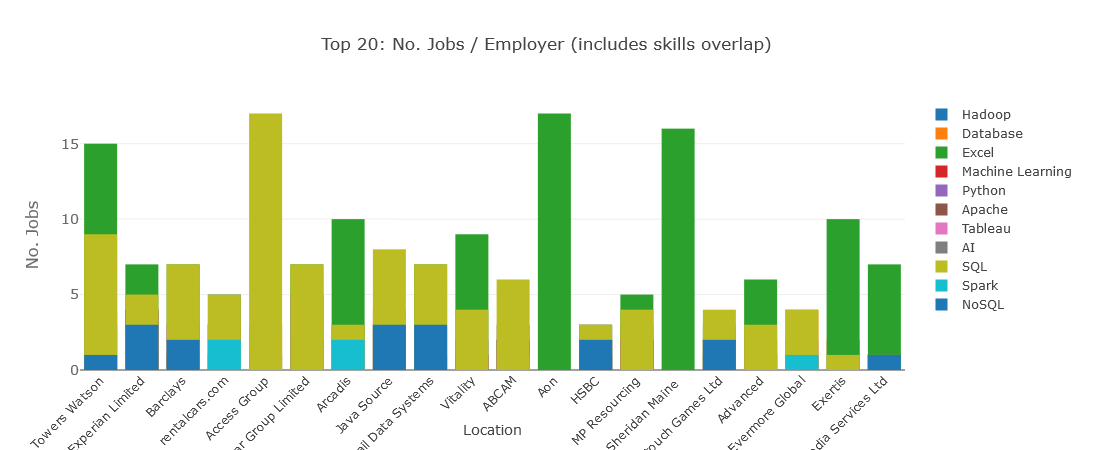

In [171]:
job_df_location = found_df.groupby(by="employerName").sum()
job_df_location['Total'] = job_df_location[list(skills_true)].sum(axis=1)

job_df_top_20 = job_df_location.nlargest(20, 'Total') # Can order by value the value of keywords by changing 'Total' to keywords[0] (Python)

top_companies_list = job_df_top_20.index.tolist()

graphs = []

for i in skills_true:
    temp = {}
    temp_df = found_df[found_df["{}".format(i)] == 1]
    temp_df = temp_df.groupby(by=["employerName"]).nunique()
    temp_df = temp_df.reindex(top_companies_list)
    temp['x'] = temp_df.index.tolist()
    temp['y'] = temp_df['jobId'].tolist()
    temp["name"] = i
    temp["type"] = "bar"
    graphs.append(temp)
            
            
layout = go.Layout(
    xaxis=dict(tickangle=-45,title='Location'), barmode='overlay',
    yaxis=dict(
        title='No. Jobs',
        titlefont=dict(
            size=16,
            color='rgb(107, 107, 107)'
        ),
        tickfont=dict(
            size=14,
            color='rgb(107, 107, 107)'
        )
    ),
    title='Top 20: No. Jobs / Employer (includes skills overlap)',
    showlegend=True
    
)

fig = go.Figure(data=graphs, layout=layout)
iplot(fig, filename='jobs_employer_skills.html')

In [172]:
found_df.query('locationName.str.contains("London")').drop_duplicates(subset=['jobId'], keep="first")

,jobId,locationName,employerName,jobTitle,minimumSalary,maximumSalary,AI,Apache,Database,Excel,Hadoop,Machine Learning,NoSQL,Python,SQL,Spark,Tableau
24,35536690,West London,Marsh & Parsons,Client Accountant,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0
229,36259077,London,Paddy Power,Data Science Manager,NaN,NaN,0,0,0,0,0,1,0,1,1,0,0
240,36388464,London,Arcadis,Lead Construction Economist,NaN,NaN,0,0,0,1,0,0,0,0,0,1,0
258,36437879,London,QA Consulting,Graduate Software Development Consultant,23500.0,26500.0,0,1,0,0,1,1,0,0,0,1,0
322,36607600,London,Mazars,Monitoring Trustee Consulting Senior Manager,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0
332,36660979,London,Deloitte,"Governance, Risk & Regulation, BrightStart Hig...",NaN,NaN,0,0,0,1,0,0,0,0,0,0,0
337,36664900,London,Edge Tech,Technical RPA Consultant,65000.0,75000.0,1,0,0,0,0,1,0,0,0,0,0
342,36674716,West London,CACI Limited,Senior Data Consultant,45000.0,55000.0,0,0,0,1,0,0,0,0,0,0,1
343,36676031,London,Arcadis,GIS/CAD Consultant& Guildford,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0
345,36678570,London,Arcadis,GIS Consultant,NaN,NaN,0,0,1,1,0,0,0,1,1,0,0
